# xcube GediDB Data Store

This notebook provides a walk-through demonstrating how to use the `xcube-gedidb` plugin to read and explore data from the GEDI API using the `gedidb` pacakge.

The `gedidb` package allows to query the data as xarray datasets in two modes: 

- request all available data within a bounding box by specifying a `bbox` in the `open_data` method.
- request all available data around a given point by specifying a `point` and `radius` in the `open_data` method.

Examples for both modes will be shown in this notebook.

In [1]:
%%time
from xcube.core.store import new_data_store, get_data_store_params_schema
import logging

CPU times: user 2.21 s, sys: 222 ms, total: 2.44 s
Wall time: 1.17 s


Executing the next cell shows that the `"gedidb"` data store does not require any further arguments for initialization.

In [2]:
get_data_store_params_schema("gedidb")

Thus, to initialize the store, simply execute:

In [3]:
store = new_data_store("gedidb")

We can set the logging level here for this plugin as follows:

In [4]:
logging.getLogger("xcube.gedidb").setLevel(logging.INFO)

In this data store, we are defining the `data_ids` as the processing level datasets that are available via [gedidb](/https://gedidb.readthedocs.io/). Note that the `data_id="all"` is the agglomeration of all processing levels. 

In [5]:
store.list_data_ids()

['L4A', 'L2B', 'L2A', 'L4C', 'all']

You can also look at the data description for each level. We get this information from the [NASA CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html)

Although, it is not retrievable via API, after reading the documentation for these datasets supported by `gedidb`, the `CRS` for all these data_ids is `EPSG:4326`. 

Links to documentation sources:

- [https://docs.terrabyte.lrz.de/datasets/gedi/introduction/](https://docs.terrabyte.lrz.de/datasets/gedi/introduction/)
- [https://lpdaac.usgs.gov/products/gedi02_av002/](https://lpdaac.usgs.gov/products/gedi02_av002/)
- [https://lpdaac.usgs.gov/documents/986/GEDI02_UserGuide_V2.pdf](https://lpdaac.usgs.gov/documents/986/GEDI02_UserGuide_V2.pdf)
- [https://lpdaac.usgs.gov/products/gedi02_bv002/](https://lpdaac.usgs.gov/products/gedi02_bv002/)


In [6]:
store.describe_data("L4A")

To view the available opening parameters, execute the following cell. To view the available variables per processing level, expand the output `JSONSchema` below into `properties.variables.enum`.

In [7]:
store.get_open_data_params_schema()

You can check the type of data that is returned from the `open_data()` method.

In [8]:
store.get_data_types()

('dataset',)

In [9]:
store.get_data_types_for_data('L4C')

('dataset',)

Now, let us use the `open_data` method to open a dataset for `L4C` and the variable `wsci` and other parameters as you can see below.

### Accessing Gedi data using `bbox`

In [10]:
%%time
gedi_data = store.open_data(
    data_id="L4C",
    variables=["wsci"],
    bbox=(30.25, -15.85, 30.42, -15.62),
    time_range=("2023-01-01", "2024-07-02"),
)
gedi_data

CPU times: user 1.17 s, sys: 2.84 s, total: 4.01 s
Wall time: 5.76 s


<xarray.Dataset> Size: 93kB
Dimensions:      (shot_number: 2583)
Coordinates:
  * shot_number  (shot_number) uint64 21kB 234630100400367828 ... 23463000040...
    latitude     (shot_number) float64 21kB -15.8 -15.8 -15.8 ... -15.75 -15.75
    longitude    (shot_number) float64 21kB 30.34 30.34 30.34 ... 30.31 30.31
    time         (shot_number) datetime64[ns] 21kB 2023-02-02 ... 2023-02-02
Data variables:
    wsci         (shot_number) float32 10kB 7.873 8.903 7.986 ... 10.15 10.28

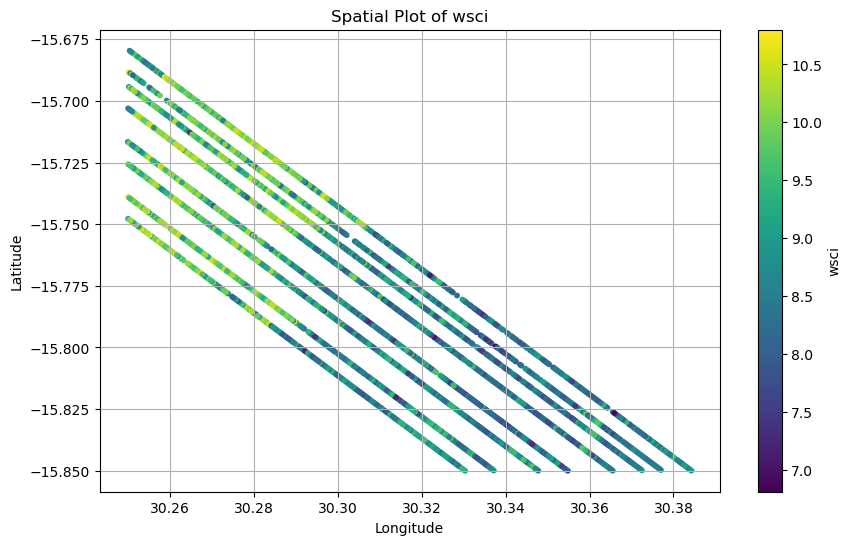

In [11]:
lat = gedi_data['latitude'].values
lon = gedi_data['longitude'].values
agbd = gedi_data['wsci'].values


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sc = plt.scatter(lon, lat, c=agbd, cmap='viridis', s=10)
plt.colorbar(sc, label='wsci')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of wsci')
plt.grid(True)
plt.show()

Now let us also include a variable from `L2A`, to do that, use `data_id="all"`

In [12]:
%%time
gedi_data = store.open_data(
    data_id="all",
    variables=["wsci", "agbd"],
    bbox=(30.25, -15.85, 30.42, -15.62),
    time_range=("2023-01-01", "2024-07-02"),
)
gedi_data

CPU times: user 1.58 s, sys: 4.72 s, total: 6.31 s
Wall time: 8.39 s


<xarray.Dataset> Size: 103kB
Dimensions:      (shot_number: 2583)
Coordinates:
  * shot_number  (shot_number) uint64 21kB 234630100400367828 ... 23463000040...
    latitude     (shot_number) float64 21kB -15.8 -15.8 -15.8 ... -15.75 -15.75
    longitude    (shot_number) float64 21kB 30.34 30.34 30.34 ... 30.31 30.31
    time         (shot_number) datetime64[ns] 21kB 2023-02-02 ... 2023-02-02
Data variables:
    agbd         (shot_number) float32 10kB 11.37 40.87 7.68 ... 119.5 149.7
    wsci         (shot_number) float32 10kB 7.873 8.903 7.986 ... 10.15 10.28

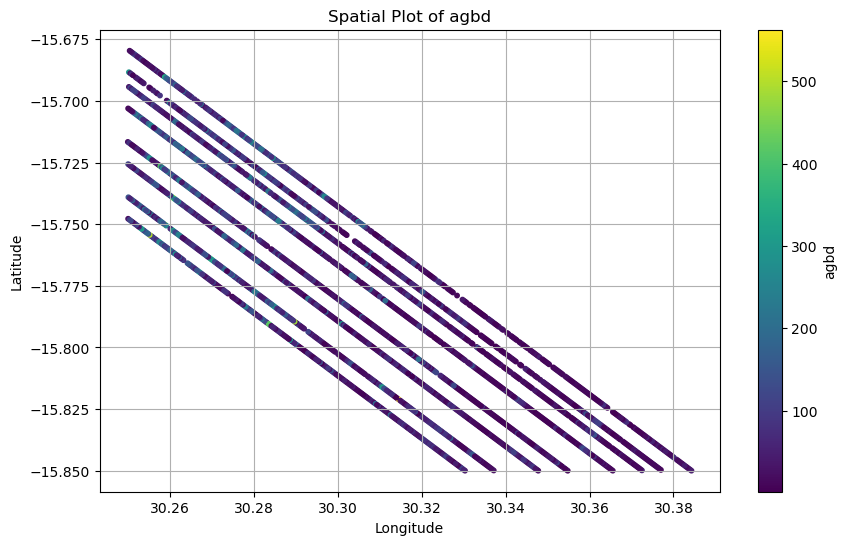

In [13]:
lat = gedi_data['latitude'].values
lon = gedi_data['longitude'].values
agbd = gedi_data['agbd'].values


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sc = plt.scatter(lon, lat, c=agbd, cmap='viridis', s=10)
plt.colorbar(sc, label='agbd')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of agbd')
plt.grid(True)
plt.show()

### Accessing Gedi data using `point`

In [14]:
%%time
gedi_data = store.open_data(
    data_id="L4C",
    variables=["wsci"],
    point=(8.94, 50.71),
    time_range=("2023-01-01", "2024-07-02"),
    num_shots=10,
    radius=0.1
)
gedi_data

CPU times: user 1.5 s, sys: 4.05 s, total: 5.55 s
Wall time: 8.72 s


<xarray.Dataset> Size: 360B
Dimensions:      (shot_number: 10)
Coordinates:
  * shot_number  (shot_number) uint64 80B 234911100300153460 ... 234911100300...
    latitude     (shot_number) float64 80B 50.72 50.72 50.72 ... 50.73 50.73
    longitude    (shot_number) float64 80B 8.947 8.946 8.943 ... 8.938 8.939
    time         (shot_number) datetime64[ns] 80B 2023-02-04 ... 2023-02-04
Data variables:
    wsci         (shot_number) float32 40B 8.1 8.151 7.062 ... 9.617 9.14 7.848

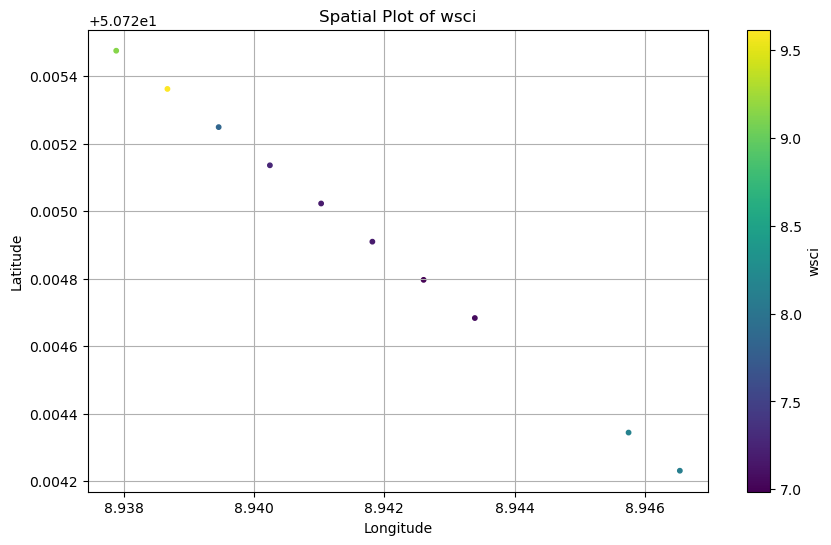

In [15]:
lat = gedi_data['latitude'].values
lon = gedi_data['longitude'].values
agbd = gedi_data['wsci'].values


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sc = plt.scatter(lon, lat, c=agbd, cmap='viridis', s=10)
plt.colorbar(sc, label='wsci')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of wsci')
plt.grid(True)
plt.show()

Now let us also include a variable from `L2A`, to do that, use `data_id="all"`

In [16]:
%%time
gedi_data = store.open_data(
    data_id="all",
    variables=["wsci", "agbd"],
    point=(8.94, 50.71),
    time_range=("2023-01-01", "2024-07-02"),
    num_shots=10,
    radius=0.1
)
gedi_data

CPU times: user 2.14 s, sys: 6.5 s, total: 8.64 s
Wall time: 13.4 s


<xarray.Dataset> Size: 400B
Dimensions:      (shot_number: 10)
Coordinates:
  * shot_number  (shot_number) uint64 80B 234911100300153460 ... 234911100300...
    latitude     (shot_number) float64 80B 50.72 50.72 50.72 ... 50.73 50.73
    longitude    (shot_number) float64 80B 8.947 8.946 8.943 ... 8.938 8.939
    time         (shot_number) datetime64[ns] 80B 2023-02-04 ... 2023-02-04
Data variables:
    agbd         (shot_number) float32 40B 27.66 28.96 23.79 ... 47.91 26.1
    wsci         (shot_number) float32 40B 8.1 8.151 7.062 ... 9.617 9.14 7.848

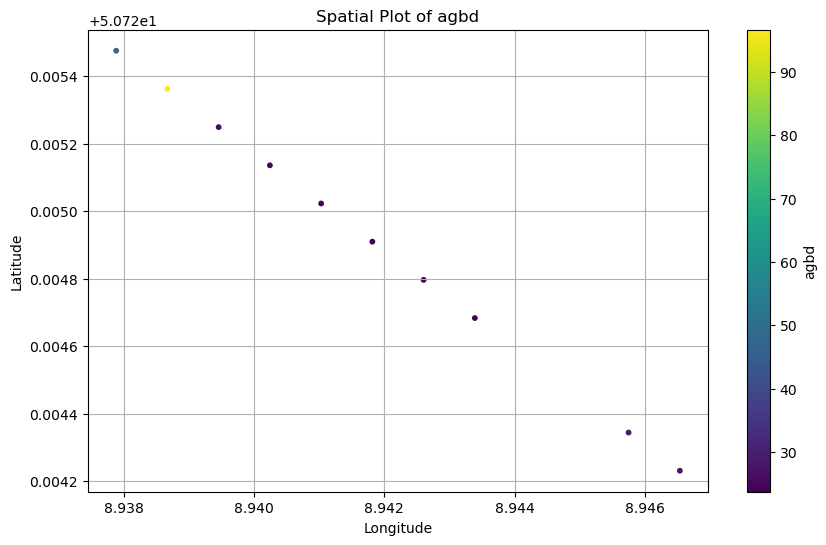

In [17]:
lat = gedi_data['latitude'].values
lon = gedi_data['longitude'].values
agbd = gedi_data['agbd'].values


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sc = plt.scatter(lon, lat, c=agbd, cmap='viridis', s=10)
plt.colorbar(sc, label='agbd')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of agbd')
plt.grid(True)
plt.show()